# Humanos vs Caballos

En los anteriores ejercicios hemos podido ver a las redes neuronales convolucionales en acción y cómo su naturaleza a través de los kernels mejora el rendimiento drásticamente.

Sin embargo, el dataset de Fashion MNIST es un dataset bastante irreal en términos de espacio y de tamaño para tareas de visión artificial reales. Una de las limitaciones más grandes al entrenar redes convolucionales es que no siempre se puede cargar todo el dataset a la memoria RAM. La memoria RAM es un recurso limitado en cualquier servidor, por lo que se debe buscar una forma más eficiente de poder realizar este tipo de tareas.

En este notebook exploraremos el caso con un dataset más cercano a lo que un ingeniero se puede encontrar *en la vida real* y cómo tratar con el mismo,


## El dataset: Humanos vs Caballos
Usaremos un dataset preparado por Laurence Moroney de Google el cual contiene imágenes sintéticas de caballos y personas. Primero tenemos que descargar tanto el conjunto de entrenamiento como el conjunto de validación o pruebas.

In [1]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip \
#     -O data/horse-or-human.zip

In [2]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip \
#     -O data/validation-horse-or-human.zip

En la siguiente celda usaremos funciones de la librería os, para acceder a librerías del sistema operativo de tal manera que podamos acceder al sistema de archivos de la máquina.


In [3]:
# import os
# import zipfile

# local_zip = 'data/horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('data/horse-or-human')
# local_zip = 'data/validation-horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('data/validation-horse-or-human')
# zip_ref.close()

Los contenidos de los archivos comprimidos .zip se extraerán en el directorio base /tmp/horse-or-human, dentro del mismo se tendrán 2 subdirectorios: `horse` y `human`

El **conjunto de entrenamiento** corresponde a los datos que se usan para decirle a la red neuronal 'así se ve un caballo'o 'así se ve una persona'.

Algo que considerar es que no estamos etiquetando explícitamente las imágenes como caballos o personas. Esto se logrará usando un dataset especial de Pytorch que es capaz de usar la estructura de nuestro dataset.

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Compose, Resize


# Define the necessary transformations
preprocess = Compose([
    ToTensor(),
    Resize((300, 300)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(root="data/horse-or-human", transform=preprocess)
test_dataset = ImageFolder(root="data/validation-horse-or-human", transform=preprocess)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [5]:
print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

1027 256
torch.Size([3, 300, 300])


## Definiendo el modelo


In [6]:
# dispositivo de entrenamiento
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Usando: {device}")

Usando: cuda


In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.head = nn.Sequential(
            nn.Linear(in_features=32768, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=2),
        )

    def forward(self, x):
        features = self.backbone(x)
        # flatten tensor
        flat_features = features.view(features.size(0), -1)
        # apply the classifier
        logits = self.head(flat_features)
        return logits
    
model = ConvNet().to(device)
print(model)

ConvNet(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


Agregamos las capas convolucionales similar al ejemplo anterior, y *aplanamos* el resultado final para continuar con las capas densamente conectadas.

Seguidamente añadimos las capas densamente conectadas.

Nótese que debido a que usamos un problema de clasificación binaria, la salida de nuestra red neuronal será una función [*sigmoide*](https://wikipedia.org/wiki/Sigmoid_function), de tal manera que la salida ser'a un escalar entre 0 y 1, se puede interpretar este valor como una probabilidad de que la imagen pertenezca a la clase 1.


In [8]:
# bucle de entrenamiento

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # modo entrenamiento
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # mover si es necesario
        X = X.to(device)
        y = y.to(device)
        # forward
        # prediccion y costo
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# funcion de pruebas
def test_loop(dataloader, model, loss_fn):
    # modo evaluacion
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # evaluacion del modelo con torch.no_grad
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Entrenamiento
Se entrenará la red por 10 épocas. Esto puede tomar algunos minutos en completarse.

Monitoree los valores en cada época.

In [9]:
learning_rate = 1e-3
batch_size = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# bucle principal
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.693094  [   64/ 1027]
loss: 1.190395  [  128/ 1027]
loss: 0.961667  [  192/ 1027]
loss: 0.684105  [  256/ 1027]
loss: 0.684440  [  320/ 1027]
loss: 0.679935  [  384/ 1027]
loss: 0.666510  [  448/ 1027]
loss: 0.650692  [  512/ 1027]
loss: 0.649761  [  576/ 1027]
loss: 0.656551  [  640/ 1027]
loss: 0.547113  [  704/ 1027]
loss: 0.516375  [  768/ 1027]
loss: 0.541574  [  832/ 1027]
loss: 0.414864  [  896/ 1027]
loss: 0.747090  [  960/ 1027]
loss: 0.560624  [ 1024/ 1027]
loss: 0.568251  [ 1027/ 1027]


/home/pepe/miniconda3/envs/cv_unifranz/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test Error: 
 Accuracy: 87.5%, Avg loss: 0.412596 

Epoch 2
-------------------------------
loss: 0.473152  [   64/ 1027]
loss: 0.450121  [  128/ 1027]
loss: 0.406924  [  192/ 1027]
loss: 0.316358  [  256/ 1027]
loss: 0.255790  [  320/ 1027]
loss: 0.310667  [  384/ 1027]
loss: 0.204080  [  448/ 1027]
loss: 0.365648  [  512/ 1027]
loss: 0.146373  [  576/ 1027]
loss: 0.211241  [  640/ 1027]
loss: 0.261377  [  704/ 1027]
loss: 0.182228  [  768/ 1027]
loss: 0.143022  [  832/ 1027]
loss: 0.091461  [  896/ 1027]
loss: 0.096425  [  960/ 1027]
loss: 0.123638  [ 1024/ 1027]
loss: 0.000009  [ 1027/ 1027]
Test Error: 
 Accuracy: 76.2%, Avg loss: 2.620710 

Epoch 3
-------------------------------
loss: 0.143363  [   64/ 1027]
loss: 0.097455  [  128/ 1027]
loss: 0.028625  [  192/ 1027]
loss: 0.061028  [  256/ 1027]
loss: 0.053366  [  320/ 1027]
loss: 0.251929  [  384/ 1027]
loss: 0.059254  [  448/ 1027]
loss: 0.199741  [  512/ 1027]
loss: 0.134535  [  576/ 1027]
loss: 0.049947  [  640/ 1027]
loss: 

### Haciendo predicciones

Vamos a usar el modelo entrenado haciendo predicciones. La celda a continuación nos permitirá subir uno o más archivos para realizar predicciones sobre los mismos.

(360, 240, 3)
torch.Size([1, 3, 300, 300])
prediction: tensor([[-13.1106,   8.0773]], device='cuda:0'), 1
 is a human


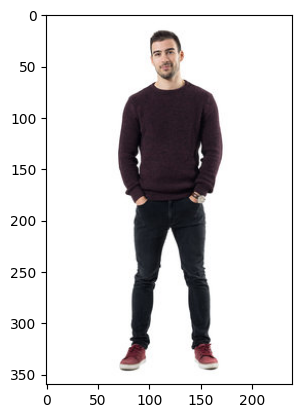

In [15]:
import numpy as np
import cv2
from torchvision.io import read_image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
# %matplotlib.inline



# img = 
# img = cv2.resize(img, (150, 150))
img = cv2.cvtColor(cv2.imread("human1.jpg"), cv2.COLOR_BGR2RGB)
# img = img[:, 200:650]
print(img.shape)
plt.imshow(img)
x = preprocess(img)
x = x.unsqueeze(0)
x = x.to(device)
print(x.shape)
model.eval()
with torch.no_grad():
    pred = model(x)
print(f"prediction: {pred}, {pred.argmax(1).item()}")
# print(pred.ar)
if pred.argmax(1).item()==1:
    print(" is a human")
else:
    print(" is a horse")
 

### Visualizando Representaciones Internas

Tambien es divertido visualizar qué tipo de filtros y qué tipo de características nuestra red ha aprendido a resaltar.

Seleccionando una imagen aleatoria en el conjunto de entrenamiento, se puede generar una figura con la salida de cada capa convolucional representando a cada filtro y su correspondiente mapa de características, las mismas se suelen llamar **representaciones internas** de la red neuronal.
